In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report
# New imports for more advanced features and a more powerful model
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2hsv, rgb2gray
from skimage.morphology import opening, closing, disk
import xgboost as xgb # Using XGBoost now

import os, sys

In [4]:
# Helper function to display images
def img_show(img, title=None, ax=None):
    if ax:
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')
    else:
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(title)
        plt.axis('off')
        plt.show()

In [5]:
patch_size = 16
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

image_dir = "training/images/"
gt_dir = "training/groundtruth/"

files = os.listdir(image_dir)
images = [mpimg.imread(image_dir + f) for f in files]
gt_images = [mpimg.imread(gt_dir + f) for f in files]


In [6]:
# --- Feature Extraction ---
# This new function now includes HOG (Histogram of Oriented Gradients) features.
# HOG is excellent for capturing local shape and edge information, which is very useful for identifying roads.
def extract_features_2(img):
    """
    Extracts 35 features from a single 16x16 image patch.
    - 12 color features (Mean and Variance of RGB and HSV)
    - 21 texture features (Histogram of LBP and HOG)
    """
    features = np.array([])
    
    # 1. Color Features (12 features)
    rgb_mean = np.mean(img, axis=(0, 1))
    rgb_var = np.var(img, axis=(0, 1))
    hsv_img = rgb2hsv(img)
    hsv_mean = np.mean(hsv_img, axis=(0, 1))
    hsv_var = np.var(hsv_img, axis=(0, 1))
    features = np.concatenate((features, rgb_mean, rgb_var, hsv_mean, hsv_var))

    # --- FIX IS HERE ---
    # Convert the floating-point grayscale image to an 8-bit integer image (0-255).
    # This is the expected format for LBP and HOG and resolves the warning and performance issue.
    gray_img_float = rgb2gray(img)
    gray_img_uint8 = (gray_img_float * 255).astype(np.uint8)
    
    # 2. Texture Features (LBP - 10 features)
    lbp = local_binary_pattern(gray_img_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9), density=True)
    features = np.concatenate((features, lbp_hist))

    # 3. NEW: Edge/Shape Features (HOG - 9 features)
    # HOG also benefits from integer images.
    hog_features = hog(gray_img_uint8, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(1, 1), visualize=False)
    features = np.concatenate((features, hog_features))
    
    return features

In [ ]:
def patch_to_label(patch):
    return int(np.mean(patch) > foreground_threshold)

# Extract patches and labels from all images
def get_all_patches_and_labels(images, gt_images):
    patch_size = 16
    img_patches = [
        img[i:i+patch_size, j:j+patch_size, :]
        for img in images
        for i in range(0, img.shape[0], patch_size)
        for j in range(0, img.shape[1], patch_size)
    ]
    gt_patches = [
        gt_img[i:i+patch_size, j:j+patch_size]
        for gt_img in gt_images
        for i in range(0, gt_img.shape[0], patch_size)
        for j in range(0, gt_img.shape[1], patch_size)
    ]
    
    X = np.asarray([extract_features_2(p) for p in img_patches])
    y = np.asarray([patch_to_label(p) for p in gt_patches])
    
    return X, y

In [13]:
# --- Prepare Data for Model Training ---
X, y = get_all_patches_and_labels(images, gt_images)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# --- Train the Model (Using XGBoost) ---
# We are now using XGBoost, a more powerful gradient boosting model.
# We will use GridSearchCV to find its best hyperparameters.
print("Training XGBoost model with GridSearchCV...")

# Define the model
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Define the parameter grid for GridSearchCV
# Note: This is a smaller grid to keep training time reasonable.
# For best results, you could expand this search.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01],
}

# Use F1 score as the metric for finding the best model
f1_scorer = make_scorer(f1_score)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring=f1_scorer, cv=3, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print("\nBest XGBoost parameters found:")
print(grid_search.best_params_)

# --- Evaluate the Model on the Hold-out Test Set ---
y_pred = best_model.predict(X_test)
print("\nClassification Report on the hold-out test set (20% of data):")
print(classification_report(y_test, y_pred, target_names=['Background', 'Road']))

Training data shape: (50000, 57)
Test data shape: (12500, 57)
Training XGBoost model with GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   1.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   1.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   1.1s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time=   1.2s
[CV] END ...learning_ra

In [ ]:
# --- Post-Processing Function ---
# This function uses morphological operations to clean up the predicted mask.
# Opening removes small noise (like salt), and closing fills small holes (like pepper).
def cleanup_mask(mask):
    """Applies morphological opening and closing to a binary mask."""
    # Use a small disk-shaped structuring element
    selem = disk(2)
    # Opening removes small bright spots (noise)
    opened_mask = opening(mask, selem)
    # Closing fills small dark holes
    closed_mask = closing(opened_mask, selem)
    return closed_mask


Applying post-processing cleanup to the prediction...


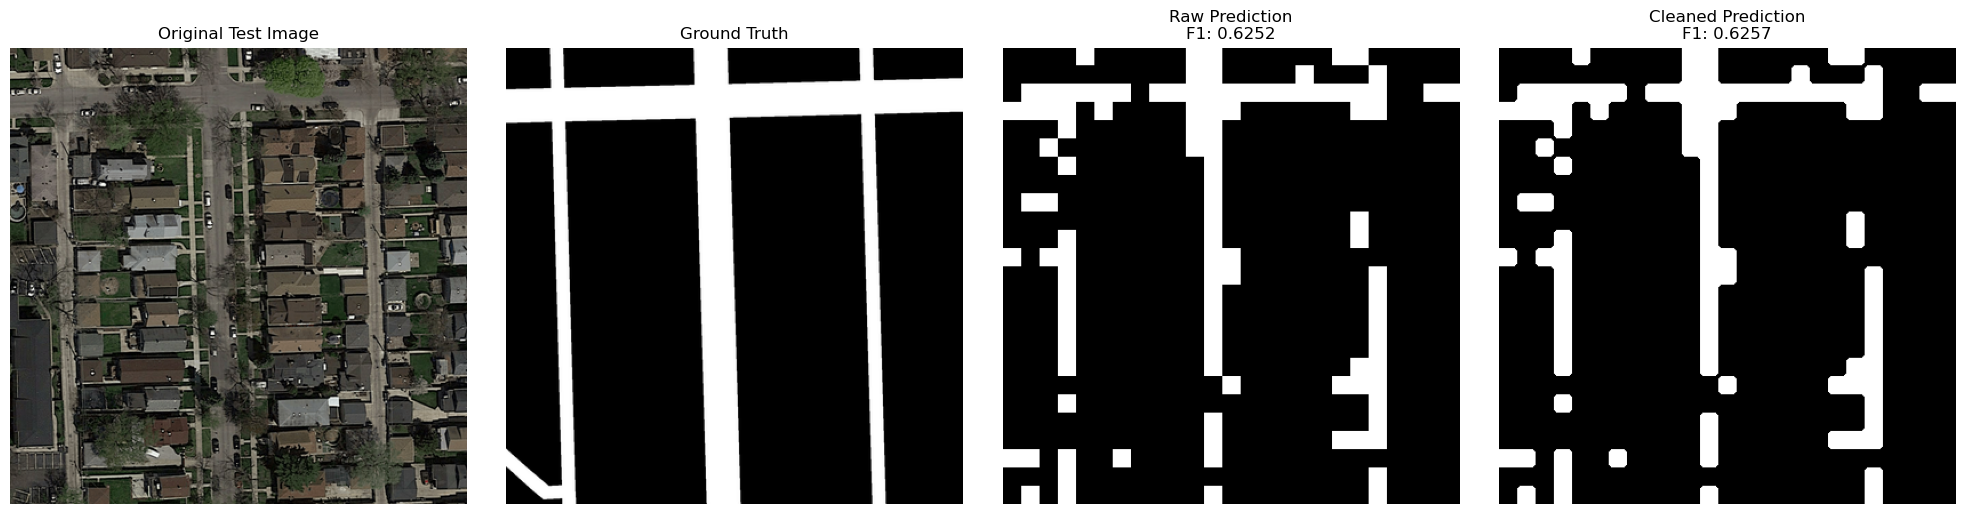


Raw Prediction F1: 0.6252.

Cleaned Prediction F1: 0.6257.


In [ ]:
# --- Prediction and Evaluation on a Test Image ---
# Let's take one image from our original set that the model hasn't seen in this exact form.
test_image_index = 50 
test_img = images[test_image_index]
test_gt = gt_images[test_image_index]

# Generate predictions for the test image
img_height, img_width, _ = test_img.shape
predicted_mask = np.zeros((img_height, img_width))

for i in range(0, img_height, patch_size):
    for j in range(0, img_width, patch_size):
        patch = test_img[i:i+patch_size, j:j+patch_size, :]
        features = extract_features_2(patch)
        prediction = best_model.predict(features.reshape(1, -1))
        predicted_mask[i:i+patch_size, j:j+patch_size] = prediction

# --- ACTIVATE POST-PROCESSING ---
print("\nApplying post-processing cleanup to the prediction...")
cleaned_predicted_mask = cleanup_mask(predicted_mask)

# --- Visualize and Compare Results ---
# We must round the ground truth mask before converting to integer type
# to avoid truncation errors from floating-point inaccuracies.
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
img_show(test_img, "Original Test Image", ax=axes[0])
img_show(test_gt, "Ground Truth", ax=axes[1])

# Calculate F1 for raw prediction
raw_f1 = f1_score(np.round(test_gt.flatten()).astype(int), predicted_mask.flatten().astype(int))
img_show(predicted_mask, f"Raw Prediction\nF1: {raw_f1:.4f}", ax=axes[2])

# Calculate F1 for cleaned prediction
cleaned_f1 = f1_score(np.round(test_gt.flatten()).astype(int), cleaned_predicted_mask.flatten().astype(int))
img_show(cleaned_predicted_mask, f"Cleaned Prediction\nF1: {cleaned_f1:.4f}", ax=axes[3])

plt.tight_layout()
plt.show()

print(f"\nRaw Prediction F1: {raw_f1:.4f}.")
print(f"\nCleaned Prediction F1: {cleaned_f1:.4f}.")